# Diffusion Models from Scratch

때로는 작동 방식을 더 잘 이해하기 위해 가능한 가장 단순한 버전을 고려하는 것이 도움이 욀 때가 있습니다. 이 노트북에서는 '장난감' 확산 모델부터 시작하여 다양한 요소가 어떻게 작동하는지 살펴본 다음, 더 복잡한 구현과 어떻게 다른지 살펴보겠습니다. 

다음 사항을 살펴봅니다. 
- The corruption process (데이터에 노이즈 추가)
- UNet이 무엇이며, 기초부터 최소한의 UNet을 구현하는 방법
- Diffusion model 학습
- 샘플링 이론 (Sampling theory)

그런 다음 우리 버전을 버전을 디퓨저 DDPM 구현과 비교하여 다음과 같이 살펴보겠습니다.
- 우리의 작은 UNet에 비해 개선된 기능
- The DDPM noise schedule
- 학습 objective의 차이
- Timestep conditioning
- 샘플링 방법

이 노트북은 상당히 심도 있는 내용을 다루고 있으므로 처음부터 자세히 살펴보고 싶지 않다면 건너뛰셔도 됩니다! 

또한 여기에 있는 대부분의 코드는 설명용이므로 학습 목적으로 여기에 표시된 예제를 개선하려는 것이 아니라면 자신의 작업에 직접 채택하는 것은 권장하지 않습니다. 

## Setup and Imports:

In [5]:
!pip install -q diffusers

In [7]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## The Data

여기서는 아주 작은 데이터 세트인 mnist로 테스트해 보겠습니다. 다른 것을 변경하지 않고 모델에 조금 더 어려운 도전을 주고 싶다면, torchvision.datasets.FashionMNIST를 드롭인 대체로 사용할 수 있습니다. 

In [8]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100.0%


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw



100.0%

Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



100.0%


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw



100.0%

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw



In [9]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 9, 0, 6, 8, 8, 9, 0])


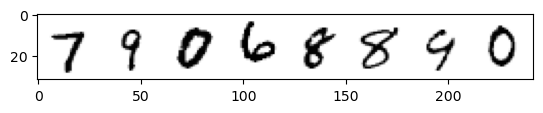

In [10]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

각 이미지는 28px $\times$ 28px 의 그레이 스케일 숫자이며, 각 픽셀은 0부터 1까지 사이의 값을 가집니다.

## The Corruption Process

확산 모델 논문을 읽지 않았지만 그 과정에 노이즈가 추가된다는 것을 알고 있다고 가정해 보겠습니다. 어떻게 하시겠습니까?

우리는 아마도 손상의 양을 쉽게 제어할 수 있는 방법을 원할 것입니다. 따라서 추가할 노이즈의 '양'에 대한 매개 변수를 입력한 다음 실행하면 어떨까요?

`noise = torch.rand_like(x)` 

`noisy_x =  (1-amount)*x + amount*noise`

만약 amount = 0 이라면, 변경 없이 입력을 반환합니다. 만약 amount가 최대 1이 되면, 입력 x의 흔적이 없는 노이즈를 반환합니다. 이런식으로 입력과 노이즈를 혼합하면 출력을 동일한 범위 (0 to 1)로 유지할 수 있습니다.

우리는 이를 아주 쉽게 구현할 수 있습니다. (broadcasting rule을 위반하지 않도록 데이터의 shape에 주의하세요): 

In [11]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

그리고 결과를 시각적으로 확인하여 예상대로 작동하는지 확인합니다:

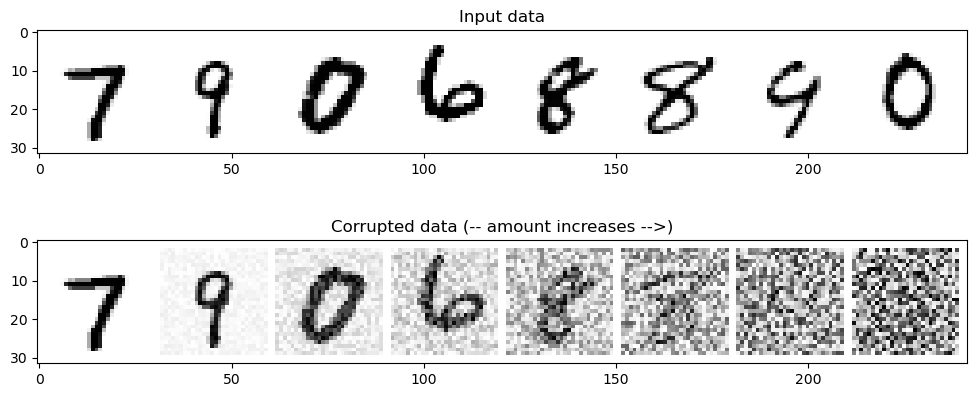

In [12]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plottinf the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

노이즈 양이 1에 가까워지면 데이터는 순수한 무작위 노이즈처럼 보이기 시작합니다. 하지만 대부분의 noie_amounts의 경우 숫자를 꽤 잘 추측할 수 있습니다. 이것이 최적의 노이즈 추가 방법이라고 생각하나요?

## The Model

28px의 노이즈가 있는 이미지를 입력받아 동일한 모양의 예측을 출력하는 모델을 만들고 싶습니다. 여기서 가장 많이 사용되는 아키텍처는 UNet이라는 아키텍처입니다. [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597), UNet은 데이터를 압축하는 '축소 경로(constricting path)'와 원래 차원으로 다시 확장하는 '확장 경로(expanding path)'로 구성되며(오토 인코더와 유사), 스킵 연결(skip connection)을 통해 다양한 레벨에서 정보와 기울기가 흐르도록 합니다. 

일부 UNet에는 각 단계마다 복잡한 블럭이 있지만, 이 toy 데모에서는 1채널 이미지를 가져와서 축소 경로(다이어그램과 코드의 down_layers)의 컨볼루션 레이어(convolution layer) 3 개와 확장 경로의 컨볼루션 레이어 3개를 통과하고 축소와 확장 사이에 스킵 연결을 사용하는 최소한의 예제를 만들어 보겠습니다. 다운샘플링에는 max pooling을 사용하고, 업샘플링에는 더 복잡한 UNet과 같은 학습 가능한 레이어에 의존하지 않고 'nn.Upsample'을 사용하겠습니다. 다음은 각 레이어 출력의 채널 수를 보여주는 대략적인 아키텍쳐입니다. 

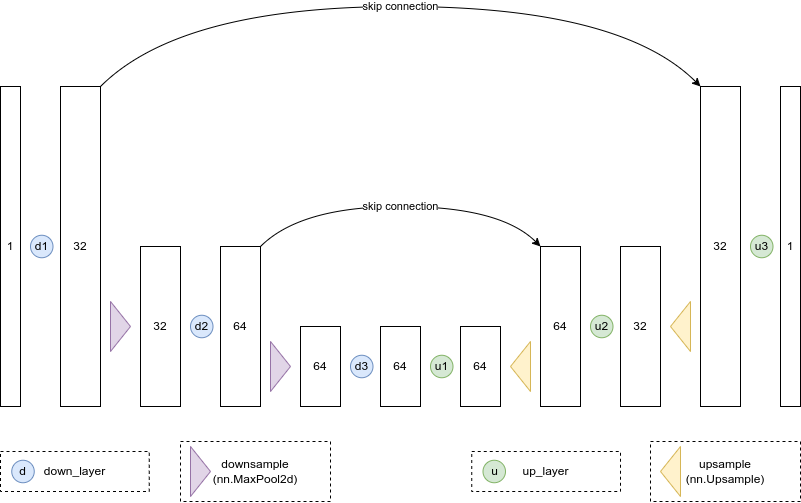

아래는 코드로 구현된 모습입니다.

In [13]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

예상대로 출력 모양이 입력과 동일한지 확인할 수 있습니다:

In [14]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

이 네트워크에는 30만 개가 조금 넘는 파라미터가 있습니다:

In [15]:
sum([p.numel() for p in net.parameters()])

309057

원하는 경우 각 레이어의 채널 수를 변경하거나 다른 아키텍처로 교체하는 방법을 살펴볼 수 있습니다.

## Training the network

그렇다면 모델은 정확히 무엇을 해야 할까요? 다시 말하지만, 다양한 방법이 있지만 이 데모에서는 간단한 프레임을 선택해보겠습니다: 손상된 입력 noisy_x 가 주어지면 모델은 원래 x가 어떻게 생겼는지에 대한 최선의 추측을 출력해야 합니다. 평균 제곱 오차(mean square error)를 통해 이를 실제 값과 비교해 보겠습니다. 

이제 네트워크를 훈련할 수 있습니다. 
- 데이터 배치 가져오기
- 랜덤한 양의 노이즈 추가하기
- 모델에 입력하기
- 손실 함수 계산을 위해 모델의 예측과 원본 이미지 비교하기
- 그에 따라 모델의 파라미터를 업데이트합니다. 

자유롭게 수정하여 더 잘 작동하는지 확인하세요!

Finished epoch 0. Average loss for this epoch: 0.026711
Finished epoch 1. Average loss for this epoch: 0.020244
Finished epoch 2. Average loss for this epoch: 0.018544


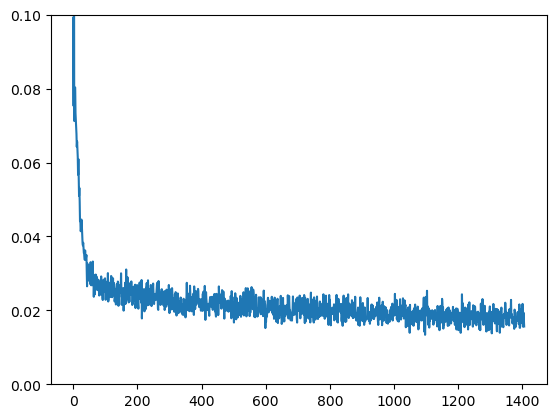

In [16]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

데이터 베치를 가져와서 다양한 양으로 데이터를 손상시킨 다음 모델 예측을 확인하여 모델 예측이 어떻게 보이는지 확인할 수 있습니다: 

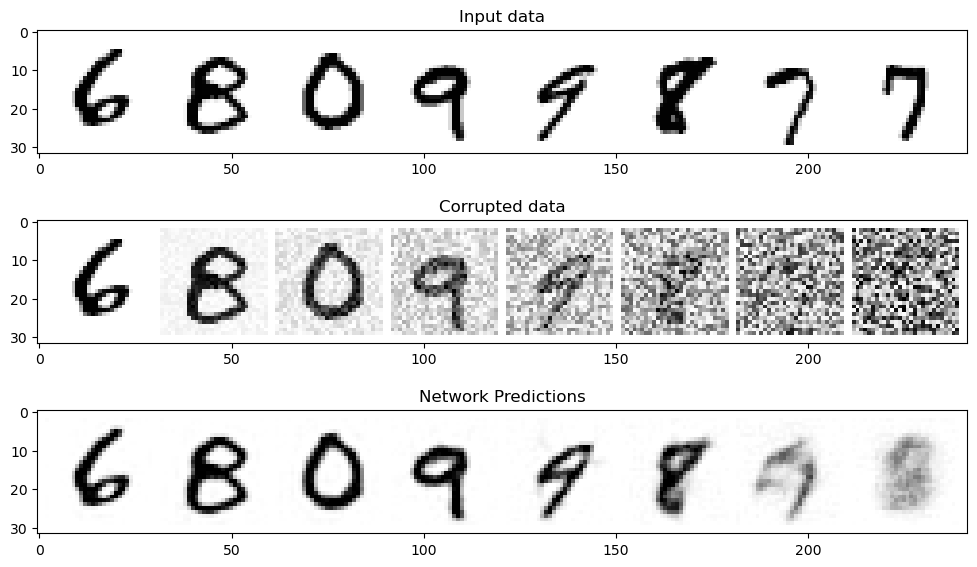

In [17]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

노이즈가 낮을 때는 예측이 꽤 괜찮다는 것을 알 수 있습니다! 그러나 노이즈 수준이 매우 높아지면 모델이 사용할 수 있는 데이터가 줄어들고, amount=1에 도달하면 데이터 집합의 평균에 가까운 흐릿한 결과를 출력하여 결과의 모양에 대한 예측을 얼버무립니다.

## Sampling

높은 노이즈 수준에서 예측이 좋지 않은 경우 이미지를 어떻게 생성할 수 있을까요?

무작위 노이즈에서 시작하여 모델 예측을 살펴본 다음, 해당 예측을 향해 20% 정도만 조금씩 이동하면 어떨까요? 이제 구조에 대한 힌트가 있는 매우 노이즈가 많은 이미지가 생겼으며, 이를 모델에 입력하여 새로운 예측을 얻을 수 있습니다. 희망은 이 새로운 예측이 첫 번째 예측보다 약간 더 낫기 때문에(시작점이 약간 덜 잡음이 많기 때문에) 이 새롭고 더 나은 예측으로 또 다른 작은 발걸음을 내딛을 수 있다는 것입니다.

몇 번 반복하면 (모든 것이 잘되면) 이미지가 나옵니다! 다음은 이 과정을 5단계에 걸쳐 설명한 것으로, 각 단계에서 모델 입력(왼쪽)과 노이즈 제거가 예측된 이미지(오른쪽)를 시각화한 것입니다. 모델이 1단계에서도 노이즈 제거된 이미지를 예측하지만, 여기서는 x만큼만 이동한다는 점에 유의하세요. 몇 단계에 걸쳐 최종 결과물을 얻을 때까지 구조가 나타나고 다듬어집니다.

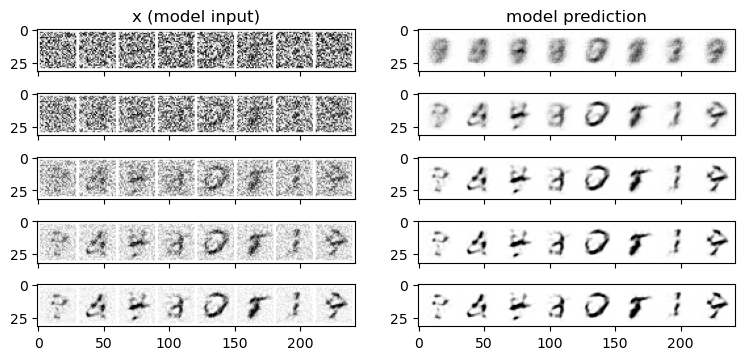

In [18]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

We can split the process up into more steps, and hope for better images that way:프로세스를 더 많은 단계로 나눌 수 있으며, 그렇게 하면 더 나은 이미지를 얻을 수 있습니다:

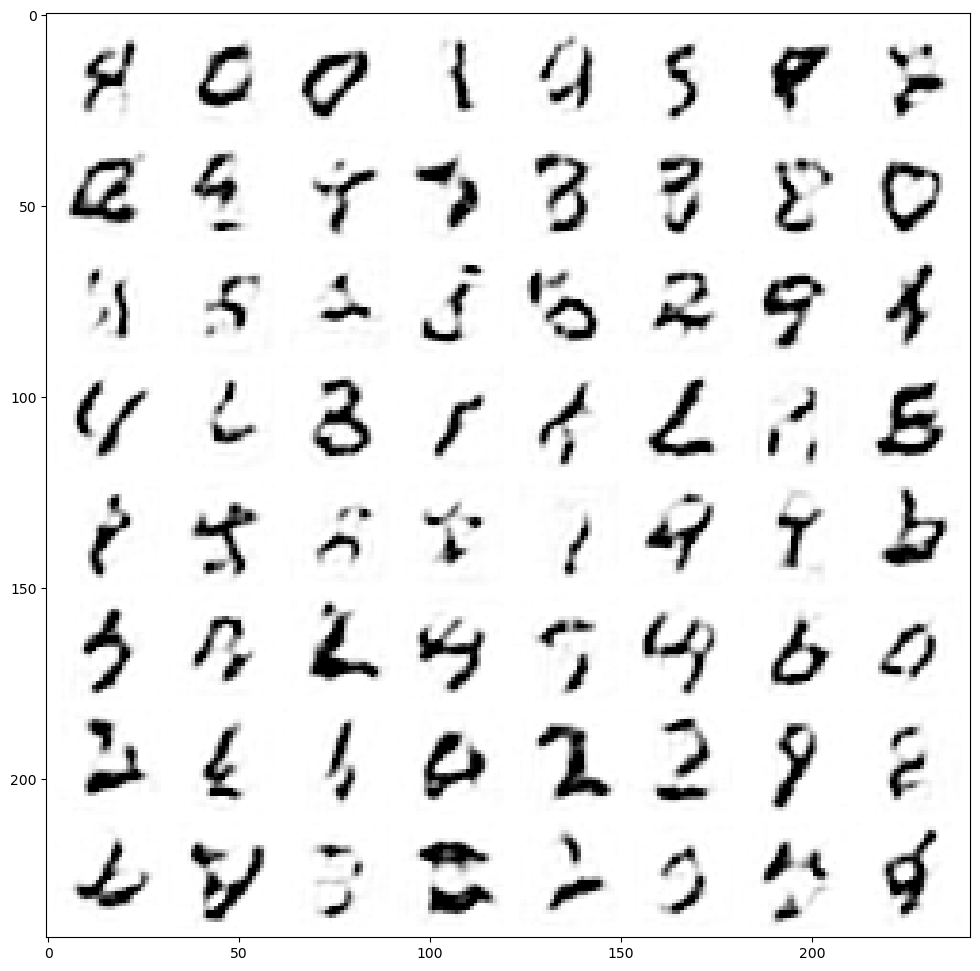

In [19]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

좋지는 않지만 알아볼 수 있는 숫자가 몇 개 있습니다! 더 긴 기간(예: 10회 또는 20회) 동안 학습하고 모델 구성, 학습 속도, 최적화 도구 등을 조정하여 실험해 볼 수 있습니다. 또한, 조금 더 어려운 데이터 세트를 시도하고 싶다면 한 줄로 대체할 수 있는 fashionMNIST도 있다는 사실을 잊지 마세요.

## Comparison To DDPM

이 섹션에서는 toy 구현이 다른 노트북에서 사용된 접근 방식과 어떻게 다른지 살펴보겠습니다. ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)), 해당 노트북은 [DDPM 논문](https://arxiv.org/abs/2006.11239)에 기반합니다.  

우리는 아래를 확인합니다.


*   디퓨져 `UNet2DModel` 는 우리의 BasicUNet보다 조금 더 발전된 모델입니다.
*   노이즈 과정은 다르게 처리됩니다.
*   학습 목적(objective)가 다르며, 노이즈가 제거된 이미지가 아니라 노이즈 예측을 포함합니다. 
*   모델은 타임스텝 컨디셔닝(timestep conditioning)을 통해 존재하는 노이즈의 양에 따라 조절되며, 여기서 t는 포워드 메서드에 대한 추가 인수로 전달됩니다.  
*   다양한 샘플링 전략을 사용할 수 있으며, 위의 간단한 버전보다 더 효과적일 수 있습니다. 

DDPM 논문이 나온 이후 여러 가지 개선사항이 제안되었지만, 이 예시를 통해 다양한 디자인 결정에 대한 지침을 얻을 수 있길 바랍니다. 이 글을 다 읽으셨으면, 본격적으로 논문을 살펴보시기 바랍니다. ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364) 위 논문에서는 모델의 구성요소를 자세히 살펴보고 최상의 성능을 얻는 방법에 대한 권장사항을 제시합니다. 

이 모든 내용이 너무 기술적이거나 어렵게 느껴지더라도 걱정하지 마세요! 이 노트의 나머지 부분은 건너뛰거나 미래에 필요해질 때를 위해 저장해두셔도 됩니다. 

### The UNet

디퓨져 UNet2DModel 모델은 위의 basicUNet에 비해 여러 개선사항이 있습니다.:

*   GroupNorm은 각 블록의 입력에 그룹 정규화를 적용
*   원활한 학습을 위한 Dropout layer
*   블록당 여러 ResNet layer (layers_per_block이 1이 아닌 경우)
*   Attention (일반적으로 lower resolution blocks에 사용)
*   타임스텝에 따른 컨디셔닝
*   학습 가능한 파라미터가 포함된 다운샘플링 및 업샘플링 블록.

UNet2DModel을 생성하고 검사해보겠습니다.:



In [20]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Con

보시다시피, 조금 더 많은 기능이 있습니다! 또한 BasicUNet보다 훨씬 더 많은 파라미터가 있습니다:

In [21]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

원래 모델 대신 이 모델을 사용하여 위에 표시된 훈련을 복제할 수 있습니다. 모델에 timestep과 x를 모두 전달해야 합니다. (여기서는 이 timestep 조건 없이도 작동한다는 것을 보여주고 샘플링 코드를 쉽게 유지하기 위해 항상 t=0을 전달하지만, 노이즈 양에서 timestep에 해당하는 값을 얻기 위해 `amount * 1000`을 입력 할수도 있습니다). 원본 코드와 달라진 부분은 `#<<<` 로 표시됩니다. 

Finished epoch 0. Average loss for this epoch: 0.020485
Finished epoch 1. Average loss for this epoch: 0.013035
Finished epoch 2. Average loss for this epoch: 0.011714


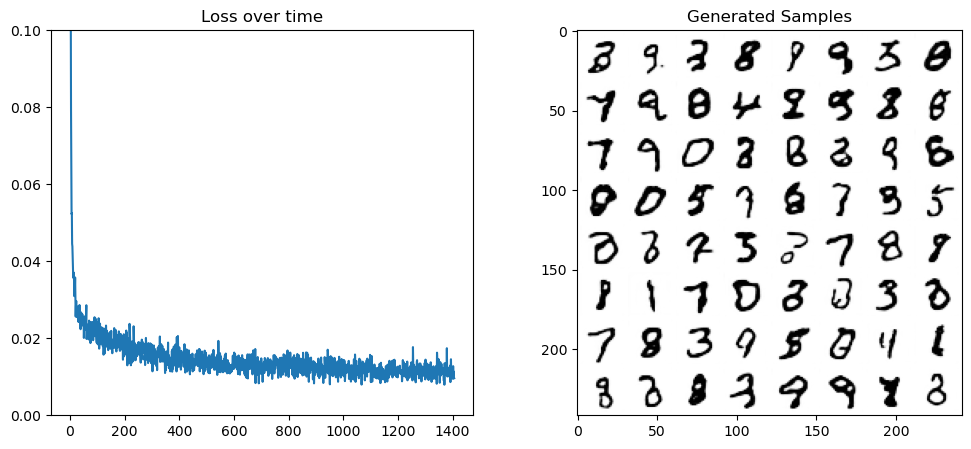

In [22]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

첫 번째 결과보다 꽤 좋아 보입니다! 더 나은 성능을 얻기 위해 unet 구성을 조정하거나 더 오래 훈련할 수 있습니다. 

### The Corruption Process

DDPM 문서에서는 모든 '타임스텝'마다 소량의 노이즈를 추가하는 손상 프로세스(corruption process)에 대해 설명합니다. $x_{t-1}$이 주어지면 다음(약간 더 노이즈가 많은) 버전$x_t$를 얻을 수 있습니다: <br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


즉 우리는 $\sqrt{1 - \beta_t}$로 스케일링 된  $x_{t-1}$에 $\beta_t$ 로 스케일링 된 노이즈를 추가합니다. 이 $\beta$ 는 매 t마다 정의되며, 타임스텝당 얼마나 많은 노이즈가 추가되는지를 결정합니다. 이제 우리는 $x_{500}$ 를 구하기 위해 이 연산을 500번 할 필요는 없으므로 주어진 $x_0$에 대해 $x_t$를 구하는 다른 공식을 사용할 수 있습니다.: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

수학 표기법은 항상 무섭게 보입니다! 다행히 scheduler가 모든 것을 처리합니다(코드를 확인하려면 다음 셀의 주석처리를 해제하세요). 우리는 어떻게 입력 x와 노이즈가 타임스텝이 달라짐에 따라 섞이고 스케일링 되는지  $\sqrt{\bar{\alpha}_t}$ (`sqrt_alpha_prod`로 라벨링됨) 와 $\sqrt{(1 - \bar{\alpha}_t)}$ (`sqrt_one_minus_alpha_prod`로 라벨링됨) 의 그래프로 확인할 수 있습니다.:


In [27]:
#??noise_scheduler.add_noise

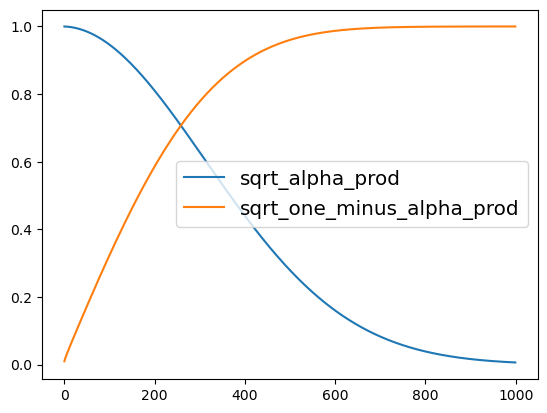

In [28]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"sqrt_alpha_prod")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"sqrt_one_minus_alpha_prod")
plt.legend(fontsize="x-large");

처음에는 노이즈가 있는 x가 대부분 x(sqrt_alpha_prod ~= 1)이지만, 시간에 따라 x의 기여도가 떨어지고 노이즈 성분이 증가합니다. `amount`에 따른 x와 노이즈의 선형 혼합과는 달리, 이 데이터는 상대적으로 빠르게 노이즈가 발생합니다. 일부 데이터에서는 이를 시각화 할 수 있습니다. 

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


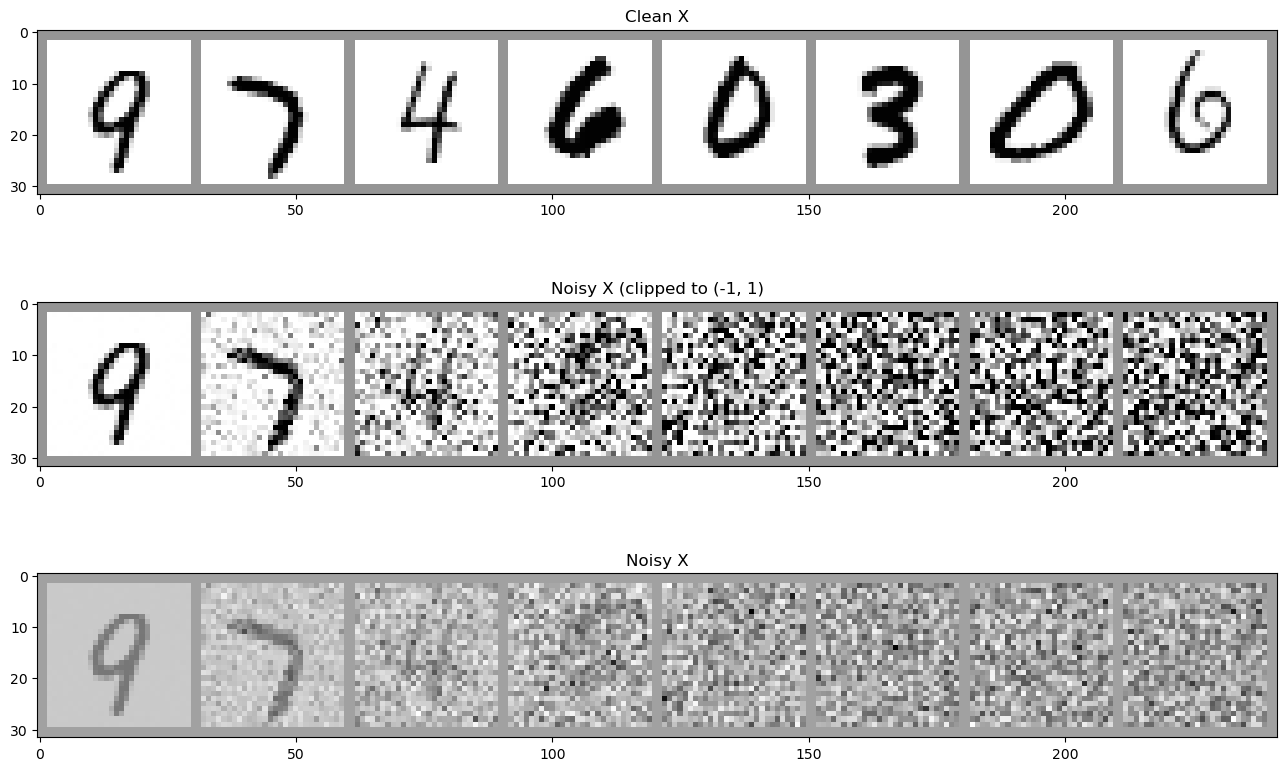

In [29]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

또 다른 역학 관계: DDPM은 원래 노이즈 함수에서 사용한 0과 1사이의 uniform 노이즈(from torch.rand) 대신 Gaussian distribution 에서 가져온 노이즈(mean 0, s.d. 1 from torch.randn)를 추가합니다. 일반적으로, 학습 데이터도 정규화하는 것이 좋습니다. 다른 노트북에서, transformer에 `Normalize(0.5, 0.5)`가 추가되는데, 이 변환은 이미지 데이터 형식 (0, 1)을 (-1, 1)로 매핑하는 것으로 우리의 목적에 '충분하다'는 것을 알 수 있습니다. 이 노트북에서는 그렇게 하지 않았지만, 위의 시각화 셀에는 더 정확한 크기 조정과 시각화를 위해 이 기능이 추가되어 있습니다.

### Training Objective

toy예시에서는 모델이 노이즈 제거 이미지를 예측하도록 했습니다. DDPM과 다른 많은 모델의 구조에서는, 손상 프로세스에서 사용된 노이즈를 예측합니다(스케일링 전이므로 단위 분산 노이즈). 코드에서는 아래와 같이 작성됩니다:

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

노이즈 예측(이를 통해 노이즈 제거된 이미지의 모양을 도출할 수 있음)은 노이즈 제거된 이미지를 직접 예측하는 것과 같다고 생각할 수 있습니다. 그렇다면 왜 노이즈를 예측할까요 - 수학적 편의를 위한 것일까요?

여기에는 또 다른 미묘한 점이 있습니다. 모델은 훈련동안 서로 다른(무작위로 선택된) 시간대(timestep)에 걸쳐 손실을 계산합니다. 이러한 서로 다른 목표는 이러한 손실에 대한 '암시적 가중치(implicit weighting)'를 달리하게 되는데, 노이즈을 예측하면 낮은 노이즈 수준에 더 많은 가중치가 부여됩니다. 이 '암시적 손실 가중치'를 변경하기 위해 더 복잡한 목표(objective)를 선택할 수 있습니다. 또는 더 높은 노이즈 레벨에서 더 많은 샘플을 생성하는 노이즈 스케줄을 선택할 수도 있습니다. 모델이 노이즈 수준에 따라 이미지와 노이즈의 조합으로 정의되는 '속도' v를 예측하도록 할 수도 있습니다('확산 모델의 빠른 샘플링을 위한 점진적 증류' 참조). 모델이 노이즈를 예측하도록 한 다음 약간의 이론('확산 모델의 인식 우선 훈련' 참조)을 기반으로 또는 어떤 노이즈 수준이 모델에 가장 유익한지 알아보는 실험('확산 기반 생성 모델의 설계 공간 해명' 참조)을 기반으로 노이즈의 양에 따라 손실의 크기를 조정할 수도 있습니다. 요약: 목표를 선택하면 모델 성능에 영향을 미치며, '최선의' 옵션이 무엇인지에 대한 연구가 진행 중입니다.

현재로서는 노이즈(일부 장소에서 볼 수 있는 epsilon 또는 eps)를 예측하는 것이 선호되는 접근 방식이지만, 시간이 지남에 따라 라이브러리에서 다른 목표가 지원되고 다양한 상황에서 사용될 수 있을 것으로 보입니다. 



### Timestep Conditioning

UNet2DModel는 x와 타임스텝 둘을 입력으로 받습니다. 타임스텝은 임베딩으로 전환되어 여러 위치에서 모델에 공급됩니다. 

모델에 노이즈 레벨에 대한 정보를 제공하면 작업을 더 잘 수행할 수 있다는 것이 이론의 핵심입니다. 타임스텝 없이 모델을 학습시킬 수도 있지만, 일부 경우 성능에 도움이 되는 것으로 보이며, 적어도 현재 문헌에 따르면 대부분에 구현에는 이 조건이 포함되어 있습니다. 

### Sampling

노이즈가 적용된 입력에서 존재하는 노이즈를 추정(또는 노이즈 제거 버전 예측)하는 모델이 주어지면 어떻게 새로운 이미지를 생성할 수 있을까요?

순수한 노이즈를 입력하면, 모델이 한 단계만에 노이즈 제거 버전으로 좋은 이미지를 예측할 수 있습니다.  그러나, 위의 실험을 통해 확인했듯이 보통 잘 작동하지 않습니다. 따라서 ㄷ신 모델 예측을 기반으로 여러 작은 단계르 수행하여 한 번에 조금씩 노이즈를 반복적으로 제거합니다. 

이러한 단계를 정확히 수행하는 방법은 사용되는 샘플링 방법에 따라 다릅니다. 이론을 너무 깊이 다루지는 않겠지만 몇 가지 주요 설계 질문은 다음과 같습니다:
- 얼마나 큰 단계를 밟아야 할까요? 다시 말해, 어떤 '소음 스케줄'을 따라야 할까요?
- 업데이트 스텝을 확인하기 위해 모델의 현재 예측만 사용합니까(예: DDPM, DDIM 및 기타 여러 가지)? 더 크고 정확한 단계를 위해 더 높은 차수의 기울기를 추정하기 위해 모델을 여러 번 평가하나요(고차 방법 및 일부 이산 ODE 솔버)? 아니면 현재 업데이트 단계(선형 멀티 스텝 및 과거 샘플러)에 더 나은 정보를 제공하기 위해 과거 예측 기록을 보관하고 있나요?
- 샘플링 프로세스에 더 많은 확률성(무작위성)을 추가하기 위해 추가적인 노이즈(churn 이라고도 함)를 추가하나요, 아니면 완전히 결정론적으로 유지하나요? 많은 샘플러는 사용자가 선택할 수 있도록 매개변수(예: DDIM 샘플러의 경우 'eta')로 이를 제어합니다.

디퓨전 모델에 대한 샘플링 방법에 대한 연구는 빠르게 발전하고 있으며, 더 적은 단계로 좋은 솔루션을 찾는 방법이 점점 더 많이 제안되고 있습니다. 디퓨전 모델에 관심이 있으신 분들은 디퓨저 라이브러리 [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) 에서 제공되는 다양한 구현의 코드를 찾아보거나 관련 논문으로 연결되는 링크 [docs](https://huggingface.co/docs/diffusers/api/schedulers) 를 확인해보는것도 흥미로울 것입니다.

## Conclusions

조금 다른 각도에서 확산 모델을 살펴보는 데 도움이 되었기를 바랍니다. 

이 노트북은 Jonathan Whitaker가 이 허깅 페이스 강좌를 위해 작성한 것으로, 다음과 겹치는 부분이 있습니다. [version included in his own course](https://johnowhitaker.github.io/tglcourse/dm1.html), 'The Generative Landscape'. 이 기본 예제를 노이즈 및 클래스 컨디셔닝으로 확장한 것을 보고 싶으시다면 여기를 확인하세요. 질문이나 버그는 GitHub 이슈 또는 Discord를 통해 전달할 수 있습니다. 트위터를 통해서도 문의하실 수 있습니다. [@johnowhitaker](https://twitter.com/johnowhitaker).